### Notebook for testing model functions with input data and examining output

To do, longer term:
* hydrology model uses a sustainable flow parameter, as in INCA. This is a fudge and needs replacing
* Add saturation excess to quick flow
* See notes in Word doc on the sediment equations, together with a to do list specifically relating to suspended sediment
* As sediment equations don't use stream velocity, the only thing it's used in at the moment is to calculate the reach time constant. Excessive, as it's two parameters? Can't re-calculate using v=Q/A, as it becomes circular when you try to work out T and V. Other options to reduce the number of parameters?
* What to do about quick flow? Should it vary by land use type? And if so, how? No quick flow apart from from agricultural land? Or quick flow from both, but more from agricultural land?
* Investigate whether having quick flow separated between agricultural and semi-natural land means that there's no longer the need for them to have different time constants
* Standard percentage runoff (annual) - compare my results to this? And how does SPR vary between soil/land use classes? Use as a guide to inform how the proportion or rainfall contributing to runoff varies between classes? (Thanks Nikki B for this thought)
* Option for dynamic effluent P inputs, i.e. option to read in a time series
* Option for dynamic terrestrial P inputs
* Option for dynamic groundwater TDP concentration, somehow linked to what's happening overhead
* Move snow accumulation and melt parameters to the main model

To do, short term:
* TDP to SRP conversion. Best means of doing this? Do individually for agricultural and effluent inputs, and then combine?
* Mitigation measures: sediment. Connectivity factor? Or just overall % reduction factor?
* Sediment and time: include time-varying factor describing change in erodibility with time on arable land, for when crops are bare?
* Maybe change names of the two agricultural land use classes, so they're just A1 and A2, i.e. less prescriptive.

In [246]:
# Import modules
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, mpld3
from scipy import optimize
import numpy as np, pandas as pd
from scipy.integrate import odeint
from scipy.stats import norm
sn.set_context('notebook')

In [247]:
# USER INPUT

# Input file paths

## Laptop
# metdata_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\Tar_AvMetData_1981-2010.csv'
# Qobsdata_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\obs_csvs\Coull_9amDailyMeanQ_oldRating.csv'
# chemObsData_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\obs_csvs\WholePeriod\TarChem_R4_SS-P.csv'
# params_fpath = r'C:\Users\lj40184\Desktop\WorkAtHome\ModelInputs\parameters.xlsx'

# Desktop
metdata_fpath = r'M:\Working\NewModel\ModelInputs\Tar_AvMetData_1981-2010.csv'
Qobsdata_fpath = r'M:\Working\NewModel\ModelInputs\obs_csvs\Coull_9amDailyMeanQ_oldRating.xlsx'
chemObsData_fpath = r'M:\Working\NewModel\ModelInputs\obs_csvs\WholePeriod\TarChem_R4_SS-P.xlsx'
params_fpath = r'M:\Working\NewModel\ModelInputs\parameters_v2.xlsx'

# Run mode. One of 'cal', 'val' (in future: 'scenario'; not implemented yet). Determines whether the soil 
# sorption coefficient, Kf, is calculated (calibration period) or read in as a parameter (validation period)
# Scenario mode is the same as validation mode, but observed data is not read in (not yet implemented)
run_mode = 'cal'  # 'cal', 'val', or 'scenario'

# Simulation period
st_dt = '2004-06-01'  # Start date
end_dt = '2005-08-31' # End date

# Number of sub-catchments
n_SC = 1

# Model options for whether variables/inputs are dynamic or constant. 'y' or 'n'.
# ***NB Only the 'Dynamic_EPC0' option is implemented at the moment. Rest are on the 'to do' list.
dynamic_dict = {'Dynamic_EPC0':'n', 'Dynamic_effluent_inputs': 'n',
                'Dynamic_terrestrialP_inputs': 'n'}

# Include snow melt and accumulation module? 0 or 1
inc_snowmelt = 1

# Snow melt parameters
D_snow_0 = 0.  # Initial snow depth (mm)
f_DDSM = 2.74  # Degree-day factor for snow melt (mm/degree-day deg C)


In [248]:
# Unit conversions
# Throughout, A_catch has units of km2
def UC_Q(Q_mmd, A_catch):
    """Convert discharge from units of mm/day to m3/day"""
    Q_m3d = Q_mmd*1000*A_catch
    return Q_m3d

def UC_Qinv(Q_m3s, A_catch):
    """Convert discharge from units of m3/s to mm/day"""
    Q_mmd = Q_m3s * 86400/(1000*A_catch)
    return Q_mmd

def UC_C(C_kgmm, A_catch):
    """Convert concentration from units of kg/mm to mg/l
    Divide answer by 10**6 to convert from mg/mm to mg/l"""
    C_mgl = C_kgmm/A_catch
    return C_mgl

def UC_Cinv(C_mgl, A_catch):
    """Convert concentration from units of mg/l to kg/mm"""
    C_kgmm = C_mgl*A_catch
    return C_kgmm
    
def UC_V(V_mm, A_catch, outUnits):
    """Convert volume from mm to m^3 or to litres. outUnits 'm3' or 'l'"""
    factorDict = {'m3':10**3, 'l':10**6}
    V = V_mm * factorDict[outUnits] * A_catch
    return V

In [249]:
# SNOW ACCUMULATION AND MELT

# Source for priors for DDF: http://directives.sc.egov.usda.gov/OpenNonWebContent.aspx?content=17753.wba
# To Do:
# (1) Add options for how temperature is assumed to vary through the day. At the moment, assume average
# temperature throughout the day. In future, could look at triangular or sinuosoidal variations throughout
# the day, to get a more accurate portrayal of the degree-days above the threshold.
# Also assumes no melting below 0 deg C.

# (2) Consider setting ET to 0 when D_snow > 0.

def hydrol_inputs(D_snow_0, f_DDSM, met_df):
    """Function to calculate snow accumulation and melt.
    Calculates total hydrological input to soil box as precipitation as rain + snowmelt
    
    D_snow_0: Initial snow depth (mm)
    f_DDSM: Degree-day factor for snow melt (mm/degree-day deg C)
    met_df: Dataframe of met data with cols T_air, PET, Pptn
    
    Returns met_df with additional columns [P_snow, P_rain, P_melt, D_snow_start
    D_snow_end, P]
    
    Of these, P is the hydrological input to the soil store
    """

    # Calculate precipitation falling as snow and add to met_df
    met_df.loc[:,'P_snow'] = met_df['Pptn'].ix[met_df['T_air']<0]
    met_df['P_snow'].fillna(0, inplace=True)

    # Calculate precipitation falling as rain and add to met_df
    met_df['P_rain'] = met_df['Pptn'] - met_df['P_snow']

    # Calculate daily snow melt, if unlimited snow pack depth to melt (mm/day)
    met_df['P_melt'] = f_DDSM*(met_df['T_air']-0)
    met_df['P_melt'][met_df['P_melt']<0]=0  # Set negative values to 0

    # Calculate snow pack depth
    met_df['D_snow_start'] = np.nan
    met_df['D_snow_end'] = np.nan

    # First time-step manually, to take initial condition into account
    met_df.ix[0,'D_snow_start'] = D_snow_0 #Assign start snow depth to first row
    met_df.ix[0,'P_melt'] = np.minimum(met_df.ix[0,'P_melt'],met_df.ix[0,'D_snow_start'])
    met_df.ix[0,'D_snow_end'] = met_df.ix[0,'D_snow_start']+met_df.ix[0,'P_snow']-met_df.ix[0,'P_melt']

    # Calculate for subsequent days
    for idx in range (1,len(met_df)):
        met_df.ix[idx,'D_snow_start'] = met_df.ix[idx-1,'D_snow_end']
        met_df.ix[idx,'P_melt'] = np.minimum(met_df.ix[idx,'P_melt'],met_df.ix[idx,'D_snow_start'])
        met_df.ix[idx,'D_snow_end'] = met_df.ix[idx,'D_snow_start']+met_df.ix[idx,'P_snow']-met_df.ix[idx,'P_melt']

    # Hydrological input to soil box
    met_df.loc[:,'P'] = met_df['P_rain'] + met_df['P_melt']
    
    return met_df

In [250]:
def P_model_v2_beta(met_df, p_LU, p_SC, p, dynamic_dict, run_mode, step_len=1):
    """
    Simple hydrology, sediment and phosphorus model, with processes varying by land use,
    sub-catchment and reach.

    Inputs:
        met_df         Dataframe containing columns 'P', the precipitation+snowmelt input to
                       the soil box, and 'PET' (units mm)

        p              Series of parameter values which don't vary by land use (index: param name)
        
        p_LU           Dataframe of parameter values which vary by land use
                       Index:   parameter name
                       Columns: 'A', 'S', 'IG' (agricultural, semi-natural, improved grassland)
                                IG only has values for parameter 'E_land' (soil erodibility), in
                                which case value in 'A' column is for arable land
        
        p_SC           Dataframe of parameter values which vary by sub-catchment or reach
                       Index:   parameter name
                       Columns: 1, 2, ...n sub-catchments

        dynamic_dict   Dictionary of options controlling whether inputs/variables are calculated
                       dynamically or kept constant.
                       Dictionary keys: 'Dynamic_EPC0', 'Dynamic_effluent_inputs',
                                        'Dynamic_terrestrialP_inputs', 'Dynamic_GW_TDP'. 'y' or 'n'
                       **NB only the first is implemented in the model at the moment***

        run_mode       'cal' or 'val'. Determines whether the soil sorption coefficient, Kf,
                       is calculated (calibration period) or read in (validation period)

        step_len       Length of each step in the input dataset (days). Default=1

    Returns a three-element tuple (df, Kf):
    
    1)  df_TC_dict: A dictionary containing dataframes of results for the terrestrial compartment,
        with one dataframe per sub-catchment (key is the sub-catchment number as an integer).
        The dataframe has column headings:
        
        VsA:          Soil water volume, agricultural land (mm)
        VsS:          Soil water volume, semi-natural land (mm)
        QsA:          Soil water flow, agricultural land (mm/d)
        QsS:          Soil water flow, semi-natural land (mm/d)
        Vg:           Groundwater volume (mm)
        Qg:           Groundwater flow (mm/d)
        Qq:           Quick flow (mm/d)
        Mland_A:      Sediment mass delivered to the stream, arable land (kg/d),
        Mland_IG:     Sediment mass delivered to the stream, improved grassland (kg/d)
        Mland_S:      Sediment mass delivered to the stream, semi-natural land (kg/d)
        P_labile_A:   Labile soil P mass in agricultural soil (kg)
        P_labile_NC:  Labile soil P mass in newly-converted agricultural or semi-natural land (kg)
        EPC0_A_kgmm:  EPC0 in agricultural soil (kg/mm)
        EPC0_NC_kgmm: EPC0 in newly-converted agricultural or semi-natural soil (kg/mm)       
        TDPs_A:       Soil water TDP mass, agricultural land (kg)
        TDPs_NC:      Soil water TDP mass, newly-converted agricultural or semi-natural land (kg)

    2)  df_R_dict: A dictionary containing dataframes of results for the stream reach, with one
        dataframe per sub-catchment (dictionary key is the sub-catchment number as an integer).
        Dataframe column headings:
        
        Vr:   Reach volume (mm)
        Qr:   Mean daily discharge from the reach (mm/d)
        Msus: Daily flux of suspended sediment from the reach (kg/day)
        TDPr: Daily flux of TDP from the reach (kg/day)
        PPr:  Daily flux of PP from the reach (kg/day)
        
        Note that instantaneous fluxes of in-stream Q and masses of SS, PP and TDP are also
        calculated by the model, and could be saved to this output dataframe if there was a need,
        rather than these daily fluxes. However, daily fluxes are used for calculating mean
        volume-weighted concentrations.

    3)  Kf: the soil adsorption coefficient (units mm/kg Soil). From (mgP/kgSoil)(mm/kgP).
        Multiply by: 10^-6 for (mm/kgSoil), by A_catch*10^6 for (l/kgSoil)
    """
    
    #########################################################################################
    # Define the ODE system
    def ode_f(y, t, ode_params):
        """
        Define ODE system
        Inputs:
            y: list of variables expressed as dy/dx. y is determined for the end of the time step
            t: array of time points of interest
            params: tuple of input values & model parameter values
        """
        
        # Unpack params. Params that vary by LU are series, with indices ['A','S','IG'],
        # LU-varying params: T_s,P_netInput,EPC0,Mland_i
        (P, E, Qq_i, Qr_US_i, Mland_i, Msus_US_i, TDPr_US_i, PPr_US_i,
         f_A, f_Ar, f_IG, f_S, f_NC_A, f_NC_Ar, f_NC_IG, f_NC_S, NC_type,
         f_IExcess, alpha, beta, T_s, T_g, fc, L_reach, S_reach, A_catch, a_Q, b_Q, E_Q, k_EQ,
         P_netInput, EPC0_A, EPC0_NC, Kf, Msoil, TDPeff, TDPg, E_PP, P_inactive) = ode_params
        
        # Unpack initial conditions for this time step
        # Hydrology
        VsA_i = y[0] # Agricultural soil water volume (mm)
        QsA_i = y[1] # Agricultural soil water flow (mm/day)
        VsS_i = y[2] # Semi-natural soil water volume (mm)
        QsS_i = y[3] # Semi-natural soil water flow (mm/day)
        Vg_i = y[4]  # Groundwater volume (mm)
        Qg_i = y[5]  # Groundwater discharge (mm/day)
        Vr_i = y[6]  # Reach volume (mm)
        Qr_i = y[7]  # Instantaneous reach discharge (mm/day)
        #(Qr_av_i would be y[8] here, but it's 0 at the start of every time step)
        # Sediment
        Msus_i = y[9]  # Mass of suspended sediment in the stream reach (kg)
        # (Msus_out_i would be y[10], but it's 0 at the start of every time step)
        # Phosphorus
        PlabA_i = y[11] # Mass of labile P in agricultural soil (kg)
        PlabNC_i = y[12] # Mass of labile P in newly converted land class (kg)
        TDPsA_i = y[13] # Mass of TDP in agricultural soil water (kg)
        TDPsNC_i = y[14] # Mass of TDP in newly converted land class (kg)
        TDPr_i = y[15] # Mass of total dissolved P in stream reach (kg)
        # (TDPr_out_i would be y[16], but it's 0 at the start of every time step)
        PPr_i = y[17]  # Mass of particulate P in stream reach (kg)
        # (PPr_out_i would be y[18], but it's 0 at the start of every time step)
        # Soil water vol & flow for newly converted land class
        if NC_type == 'A':  # If semi-natural converted to arable, assume has arable hydrol
            VsNC_i = VsA_i
            QsNC_i = QsA_i
        else:
            VsNC_i = VsS_i  # If arable converted to SN, assume has semi-natural hydrol
            QsNC_i = QsS_i
    
        # HYDROLOGY
        
        # Soil hydrology equations (units mm or mm/day): Agricultural land
        dQsA_dV = ((((VsA_i - fc)*np.exp(fc - VsA_i))/(T_s['A']*((np.exp(fc-VsA_i) + 1)**2)))
                    +(1/(T_s['A']*(np.exp(fc-VsA_i) + 1))))
        dVsA_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*VsA_i)) - QsA_i
        dQsA_dt = dQsA_dV*dVsA_dt
        
        # Soil hydrology equations (units mm or mm/day): Semi-natural/other land
        dQsS_dV = ((((VsS_i - fc)*np.exp(fc - VsS_i))/(T_s['S']*((np.exp(fc-VsS_i) + 1)**2)))
                    +(1/(T_s['S']*(np.exp(fc-VsS_i) + 1))))
        dVsS_dt = P*(1-f_IExcess) - alpha*E*(1 - np.exp(-0.02*VsS_i)) - QsS_i
        dQsS_dt = dQsS_dV*dVsS_dt
        
        # Groundwater equations (units mm or mm/day)
        dQg_dt = (beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i)/T_g
        dVg_dt = beta*(f_A*QsA_i + f_S*QsS_i) - Qg_i
        
        # Instream equations (units mm or mm/day)
        dQr_dt = ((Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i + Qr_US_i - Qr_i) # Fluxes (mm/d)
                  *a_Q*(Qr_i**b_Q)*(8.64*10**7)/((1-b_Q)*(L_reach*1000)))
                  # 2nd row is U/L=1/T. Units:(m/s)(s/d)(mm/m)(1/m)(m/mm)
        dVr_dt = Qq_i + (1-beta)*(f_A*QsA_i + f_S*QsS_i) + Qg_i + Qr_US_i - Qr_i
        dQr_av_dt = Qr_i  # Daily mean flow
        
        # SEDIMENT
        # Instream suspended sediment (kg; change in kg/day)
        dMsus_dt = (f_Ar*Mland_i['A'] + f_IG*Mland_i['IG'] + f_S* Mland_i['S']  # From land (kg/day)
                   + E_Q*S_reach*(Qr_i**k_EQ)             # Entrainment from the stream bed (kg/d)
                   + Msus_US_i                            # Inputs from upstream
                   - (Msus_i/Vr_i)*Qr_i)                  # Outflow from the reach;(kg/mm)*(mm/day)
        
        dMsus_out_dt = Qr_i*Msus_i/Vr_i  # Daily flux of SS
        
        # PHOSPHORUS
        
        # Agricultural soil labile P mass (kg). Assume semi-natural land has no labile soil P
        dPlabA_dt = Kf*Msoil*((TDPsA_i/VsA_i)-EPC0_A)  # Net sorption
        # dPlabA_dt = (PlabA_i/EPC0_A)*((TDPsA_i/VsA_i)-EPC0_A) # Alternative sorpn formulation
        
        # Newly-conveted soil labile P mass (kg)
        dPlabNC_dt = Kf*Msoil*((TDPsNC_i/VsNC_i)-EPC0_NC)
        
        # Change in dissolved P mass in agricultural soil water (kg/day)
        # Assume semi-natural land has no dissolved soil water P
        dTDPsA_dt = ((P_netInput['A']*100*A_catch/365)  # Net inputs (fert+manure-uptake) (kg/ha/yr)
                   - Kf*Msoil*((TDPsA_i/VsA_i)-EPC0_A)  # Net sorpn (kg/day) (could be alt above)
                   - (QsA_i*TDPsA_i/VsA_i)              # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPsA_i/VsA_i))              # Outflow via quick flow (kg/day)
        
        # And in newly converted land class soil water
        dTDPsNC_dt = ((P_netInput['NC']*100*A_catch/365)    # Net inputs (kg/ha/yr)
                   - Kf*Msoil*((TDPsNC_i/VsNC_i)-EPC0_NC)   # Net sorpn (kg/day)
                   - (QsNC_i*TDPsNC_i/VsNC_i)               # Outflow via soil water flow (kg/day)
                   - (Qq_i*TDPsNC_i/VsNC_i))                # Outflow via quick flow (kg/day)
        
        # Change in in-stream TDP mass (kg/d)
        # Semi-natural inputs not specified as assume 0 for soil water & quick flow
        dTDPr_dt = ((1-beta)*f_A*QsA_i*(TDPsA_i/VsA_i)  # Soil input, old agri. Units:(mm/d)(kg/mm)
                   + (1-beta)*f_NC_A*QsNC_i*(TDPsNC_i/VsNC_i)  # Soil input, new agri land
                   + (1-beta)*f_NC_S*QsNC_i*(TDPsNC_i/VsNC_i)  # Soil input, new SN land
                   + f_A*Qq_i*(TDPsA_i/VsA_i)           # Quick input, old agri. Units:(mm/d)(kg/mm)
                   + f_NC_A*Qq_i*(TDPsNC_i/VsNC_i)      # Quick input, newly-converted agri
                   + f_NC_S*Qq_i*(TDPsNC_i/VsNC_i)      # Quick inputs, newly-converted SN
                   + Qg_i*UC_Cinv(TDPg,A_catch)         # Groundwater input. Units: (mm/d)(kg/mm)
                   + TDPeff                             # Effluent input (kg/day)
                   + TDPr_US_i                          # Inputs from upstream 
                   - Qr_i*(TDPr_i/Vr_i))                # Reach outflow. Units: (mm/d)(kg/mm)
        
        dTDPr_out_dt = Qr_i*TDPr_i/Vr_i  # Daily TDP flux out of reach. Units: (mm/d)(kg/mm)=kg/d
        
        # Change in in-stream PP mass (kg/d)
        dPPr_dt = (E_PP *
                   (f_Ar*Mland_i['A']*(PlabA_i+P_inactive)/Msoil         # Old arable land
                   + f_IG*Mland_i['IG']*(PlabA_i+P_inactive)/Msoil       # Old improved grassland
                   + f_S*Mland_i['S']*P_inactive/Msoil)                  # Semi-natural land
                   + f_NC_Ar*Mland_i['A']*(PlabNC_i+P_inactive)/Msoil    # Newly-converted arable
                   + f_NC_IG*Mland_i['IG']*(PlabNC_i+P_inactive)/Msoil   # Newly-converted IG
                   + f_NC_S*Mland_i['S']*(PlabNC_i+P_inactive)/Msoil     # New semi-natural
                   + (E_Q*S_reach*(Qr_i**k_EQ))*E_PP*(f_A*(PlabA_i+P_inactive)+f_S*P_inactive)/Msoil
                                                                         # Entrained
                   + PPr_US_i                                            # Inputs from upstream 
                   - Qr_i*(PPr_i/Vr_i))                               # Reach outflow (mm/d)(kg/mm)
        
        dPPr_out_dt = Qr_i*PPr_i/Vr_i  # Daily mean flux
        
        # Add results of equations to an array
        res = np.array([dVsA_dt, dQsA_dt, dVsS_dt, dQsS_dt, dVg_dt, dQg_dt, dVr_dt, dQr_dt,
                        dQr_av_dt, dMsus_dt, dMsus_out_dt, dPlabA_dt, dPlabNC_dt, dTDPsA_dt,
                        dTDPsNC_dt, dTDPr_dt, dTDPr_out_dt, dPPr_dt, dPPr_out_dt])
        return res
    
    ##########################################################################################
    #-----------------------------------------------------------------------------------------
    # SETUP ADMIN FOR LOOPING OVER TIME STEPS AND SUB-CATCHMENTS
    
    # Dictionary to store results in for different sub-catchments
    df_TC_dict = {} # Key: Sub-catchment number (int); returns df of terrestrial compartment results
    df_R_dict = {}  # Key: Sub-catchment number (int); returns df of in-stream (reach) results
    
    # Time points to evaluate ODEs at (we're only interested in the start and end of each step)
    ti = [0, step_len]

    #-----------------------------------------------------------------------------------------
    # INITIAL CONDITIONS AND DERIVED PARAMETERS THAT DON'T VARY BY SUB-CATCHMENT
    # Unpack user-supplied initial conditions, calculate any others, convert units
    
    # 1) Terrestrial - constant over LU and SC
    # Hydrol
    VsA0 = p['fc']   # Initial soil volume (mm). Assume it's at field capacity.
    VsS0 = VsA0      # Initial soil vol, semi-natural land (mm). Assumed same as agricultural!!
    Qg0 = p['Qg0_init']      # Initial groundwater flow (mm/d)
    
    #-----------------------------------------------------------------------------------------
    # START LOOP OVER SUB-CATCHMENTS
    for SC in p['SC_list']:
        
        # INITIAL CONDITIONS THAT VARY BY SUB-CATCHMENT
    
        # Soil mass and inactive soil P (kg)
        # Assume inactive soil P is equivalent to semi-natural total soil P for all LU classes
        Msoil = p['Msoil_m2']*10**6*p_SC.ix['A_catch',SC] # Soil mass (kg): (kgSoil/m2)(m2/km2)km2
        P_inactive = 10**-6*p_LU['S']['SoilPconc']*Msoil

        # 2) Terrestrial - varying by land use and by sub-catchment
        for LU in ['A','S']:
            # Convert units of EPC0 from mg/l to kg/mm to give initial EPC0
            p_LU.ix['EPC0_0',LU] = UC_Cinv(p_LU[LU]['EPC0_init_mgl'], p_SC.ix['A_catch',SC])
            ### CHECK units here! Should same mg/l conc give diff kg/mm conc in diff SCs?????
            
            # Initial labile P. Units: (kgP/mgP)(mgP/kgSoil)kgSoil. Assume Plab0=0 for semi-natural
            p_LU.ix['Plab0',LU] = 10**-6*(p_LU[LU]['SoilPconc']-p_LU['S']['SoilPconc']) * Msoil
            # Initial soil water TDP mass (kg); Units: (kg/mm)*mm
            if LU == 'A':
                p_LU.ix['TDPs0',LU] = p_LU[LU]['EPC0_0']*VsA0
            else:
                p_LU.ix['TDPs0',LU] = 0
                        
        # Set initial agricultural labile P and soil TDP masses as variables to be updated during
        # looping (assume semi-natural remain at 0 for both)
        Plab0_A, TDPs0_A = p_LU.ix['Plab0','A'], p_LU.ix['TDPs0','A']
        # Initial labile P and soil TDP mass on newly converted land use class
        if p_SC.ix['NC_type',SC]=='S':
            Plab0_NC = Plab0_A  # New class is SN, from arable, therefore start with arable labile P
            TDPs0_NC = TDPs0_A
        else:
            Plab0_NC = 0.0      # New class is arable, from SN, therefore start with no labile P
            TDPs0_NC = p_LU.ix['TDPs0','S']

        # Set the value for Kf, the adsorption coefficient (mm/kg soil)
        if run_mode == 'cal': # If the calibration period, calculate.
            # Assume SN has EPC0=0, PlabConc =0. Units: (kg/mg)(mg/kgSoil)(mm/kg)
            Kf = 10**-6*(p_LU['A']['SoilPconc']-p_LU['S']['SoilPconc'])/p_LU['A']['EPC0_0']  
        else:  # If not the calibration period, read Kf in from the series of param values
            Kf = p['Kf']

        # 3) In-stream initial conditions (all reaches the same for chem)
        TDPr0, PPr0, Msus0 = 0.0, 0.0, 0.0  # Initial TDP, PP & SS masses (kg; assume all equal 0.0)
        # Initial in-stream flow
        if SC == 1:
            # Convert units of initial reach Q from m3/s to mm/day
            Qr0 = UC_Qinv(p['Qr0_init'], p_SC.ix['A_catch',SC])
        else:        # Outflow from the reach upstream from the first time step
            Qr0 = df_R_dict[SC-1].ix[0,'Qr']  # N.B. 'Qr' here is Qr_av, the daily mean flow
        
        # ADMIN
    
        # Dictionary of slopes for different land use classes in the sub-catchment:
        slope_dict = {'A':p_SC.ix['S_Ar',SC], 'IG':p_SC.ix['S_IG',SC], 'S':p_SC.ix['S_SN',SC]}
        
        # Lists to store output
        output_ODEs = []    # From ode_f function
        output_nonODE = []  # Will include: Qq, Mland, Qr_US (latter for checking only)        
        
        #-------------------------------------------------------------------------------------
        # START LOOP OVER MET DATA
        for idx in range(len(met_df)):

            # Get precipitation and evapotranspiration for this day
            P = met_df.ix[idx, 'P']
            E = met_df.ix[idx, 'PET']

            # Calculate infiltration excess (mm/(day * catchment area))
            Qq_i = p['f_IExcess']*P
            
            # Inputs to reach from up-stream reaches
            if SC == 1:
                # For the top reach, set the input from upstream reaches to 0
                Qr_US_i, Msus_US_i, TDPr_US_i, PPr_US_i = 0.0, 0.0, 0.0, 0.0
            else:
                # Below reach 1, the upstream input is the daily mean flux from up-stream for the
                # current day
                Qr_US_i = df_R_dict[SC-1].ix[idx,'Qr']
                Msus_US_i = df_R_dict [SC-1].ix[idx, 'Msus']
                TDPr_US_i = df_R_dict [SC-1].ix[idx, 'TDPr']
                PPr_US_i = df_R_dict [SC-1].ix[idx, 'PPr']

            # Calculate delivery of sediment from the land to the stream (kg/day). NB this flux
            # assumes the land use covers the whole catchment. Divide by area to get areal flux
            Mland_i = pd.Series(3*[np.NaN],['A','S','IG']) # Empty series to store results in later
            dayNo = met_df.index[idx].dayofyear  # Day of the year (1 to 365)
            for LU in ['A','S','IG']:
                # If arable land, work out a dynamic crop cover factor, to account for the variation
                # in erodibility through the year due to harvesting and planting practices.
                # Differentiate between spring sown and autumn sown crops, and area-weight
                # The average of the dynamic cover factor over a year equals the user-input factor
                # (which is the ratio of erosion expected under the land use compared to bare soil)
                if LU == 'A':
                    R_spr = p_SC.ix['f_spr',SC]/p_SC.ix['f_Ar',SC] # Ratio, spring:autumn-sown crops
                    C_spr_t = p_LU[LU]['C_cover']*(-np.cos((2*np.pi/365)*dayNo + p['d_maxE_spr'])+1)
                    C_aut_t = p_LU[LU]['C_cover']*(-np.cos((2*np.pi/365)*dayNo + p['d_maxE_aut'])+1)
                    C_cover = R_spr*C_spr_t + (1-R_spr)*C_aut_t  # Area-weighted average
                # Otherwise, the vegetation cover factor is constant throughout the year
                else:
                    C_cover = p_LU[LU]['C_cover']
                # Sediment yield per land use class (kg/d). See documentation for rationale/source
                Mland_i[LU] = 10**5* (p['E_land'] * slope_dict[LU] * (Qq_i**p['k_Eland'])
                              #* 10**6 *(p_SC.ix['A_catch',SC]/p_SC.ix['L_reach',SC])  # Drop this?
                              * p_SC.ix['K_erosion',SC] * C_cover * (1-p_LU[LU]['Sed_measures']))

            # Calculate dynamic EPC0 as a function of labile P mass
            if dynamic_dict['Dynamic_EPC0'] == 'y':
                EPC0_A_i = Plab0_A/(Kf*Msoil) # Agricultural EPC0; equals EPC0_0 on the 1st timestep
                EPC0_NC_i = Plab0_NC/(Kf*Msoil) # EPC0 on newly-converted land
            # Or, have a constant EPC0 throughout the model run
            else:
                EPC0_A_i = p_LU['A']['EPC0_0']
                if p_SC.ix['NC_type',SC] == 'S': # (little point in a new class with constant EPC0)
                    EPC0_NC_i = p_LU['A']['EPC0_0']  # New semi-natural land has agricultural EPC0
                else:
                    EPC0_NC_i = p_LU['S']['EPC0_0']  # New agricultural has SN EPC0

            # Append to non-ODE results
            output_nonODE_i = [Qq_i, Mland_i['A'],Mland_i['IG'],Mland_i['S'], EPC0_A_i, EPC0_NC_i]
            output_nonODE.append(output_nonODE_i)

            # Calculate additional initial conditions from user-input values/ODE solver output
            # Soil flow, agricultural (mm/d)
            QsA0 = (VsA0 - p['fc'])/(p_LU['A']['T_s']*(1 + np.exp(p['fc'] - VsA0)))
            # Soil flow, semi-natural (mm/d)
            QsS0 = (VsS0 - p['fc'])/(p_LU['S']['T_s']*(1 + np.exp(p['fc'] - VsS0)))
            Vg0 = Qg0 *p['T_g']     # Groundwater vol (mm)
            Tr0 = ((1000*p_SC.ix['L_reach',SC])/
                   (p['a_Q']*(Qr0**p['b_Q'])*(8.64*10**7))) # Reach time constant (days); T=L/aQ^b
            Vr0 = Qr0*Tr0 # Reach volume (V=QT) (mm)

            # Vector of initial conditions for start of time step (assume 0 for initial Qr_av,
            # Msus_out, TDPr_out and PPr_out, the mass or vol of water lost per time step
            y0 = [VsA0, QsA0, VsS0, QsS0, Vg0, Qg0, Vr0, Qr0, 0.0, Msus0, 0.0, Plab0_A, Plab0_NC,
                  TDPs0_A, TDPs0_NC, TDPr0, 0.0, PPr0, 0.0]

            # Today's rainfall, ET & model parameters for input to solver. NB the order must be the
            # same as the order in which they are unpacked within the odeint function
            ode_params = [P, E, Qq_i, Qr_US_i, Mland_i, Msus_US_i, TDPr_US_i, PPr_US_i,
                          p_SC.ix['f_A',SC],p_SC.ix['f_Ar',SC],p_SC.ix['f_IG',SC],p_SC.ix['f_S',SC],
                          p_SC.ix['f_NC_A',SC],p_SC.ix['f_NC_Ar',SC],p_SC.ix['f_NC_IG',SC],
                          p_SC.ix['f_NC_S',SC],p_SC.ix['NC_type',SC],
                          p['f_IExcess'],p['alpha'], p['beta'],
                          p_LU.ix['T_s'], p['T_g'], p['fc'],
                          p_SC.ix['L_reach',SC], p_SC.ix['S_reach',SC], p_SC.ix['A_catch',SC],
                          p['a_Q'], p['b_Q'], p['E_Q'], p['k_EQ'],
                          p_LU.ix['P_netInput'], EPC0_A_i, EPC0_NC_i, Kf, Msoil,
                          p_SC.ix['TDPeff',SC], p['TDPg'], p['E_PP'], P_inactive]

            # Solve ODEs
            y = odeint(ode_f, y0, ti, args=(ode_params,))

            # Extract values for the end of the step
            res = y[1]
            res[res<0] = 0 # Numerical errors may result in very tiny values <0; set these back to 0
            output_ODEs.append(res)

            # Update initial conditions for next step (for Vs, Qg0, Qr0, Msus0, Plab0, TDPs0)
            VsA0 = res[0]  # QsA0 would be res[1]
            VsS0 = res[2]  # QsS0 would be res[3], Vg0 would be res[4] (but calculate from Qg0)
            # Re-set groundwater to user-supplied minimum flow at start of each time step. Non-ideal
            # solution to the problem or maintaining stream flow during baseflow conditions!!!
            if p['Qg_min'] > res[5]:
                Qg0 = p['Qg_min']
            else:
                Qg0 = res[5]
            # Vr0 would be res[6], but calculate from Qr0 instead
            Qr0 = res[7]       # Qr_av_0 would be res[8], but it's always 0
            Msus0 = res[9]     # Msus_out_0 would be res[10]
            Plab0_A = res[11]
            Plab0_NC = res[12]
            TDPs0_A = res[13]
            TDPs0_NC = res[14]
            TDPr0 = res[15]    # TDPr_out_0 would be res[16], but it's always 0
            PPr0 = res[17]     # TDPr_out_0 would be res[18], but it's always 0

            # END LOOP OVER MET DATA
        #-------------------------------------------------------------------------------------
    
        # Build a dataframe of ODE results
        df_ODE = pd.DataFrame(data=np.vstack(output_ODEs),
                           columns=['VsA', 'QsA','VsS', 'QsS', 'Vg', 'Qg', 'Vr', 'Qr_instant', 'Qr',
                           'Msus_instant', 'Msus', 'P_labile_A', 'P_labile_NC', 'TDPs_A', 'TDPs_NC',
                           'TDPr_instant', 'TDPr', 'PPr_instant', 'PPr'], index=met_df.index)

        # Dataframe of non ODE results
        df_nonODE = pd.DataFrame(data=np.vstack(output_nonODE),
                                 columns=['Qq','Mland_A','Mland_IG','Mland_S',
                                'EPC0_A_kgmm', 'EPC0_NC_kgmm'], index=met_df.index)

        # Rearrange ODE and non-ODE result dataframes into results dataframes for the terrestrial
        # compartment (df_TC) and the stream reach (df_R)
        df_TC = pd.concat([df_ODE[['VsA', 'QsA','VsS', 'QsS', 'Vg', 'Qg', 'P_labile_A',
                                  'P_labile_NC','TDPs_A', 'TDPs_NC']],df_nonODE], axis=1)
        # NB masses of SS and P are all total fluxes for the day, and Q is the daily mean flow
        df_R = df_ODE[['Vr', 'Qr','Msus','TDPr', 'PPr']]
        
        # Add to dictionaries; key = sub-catchment/reach number
        df_TC_dict[SC] = df_TC
        df_R_dict[SC] = df_R
        
        # END LOOP OVER SUB-CATCHMENTS
        #-------------------------------------------------------------------------------------

    return (df_TC_dict, df_R_dict, Kf)  # NB Kf is returned for the last SC

In [251]:
# READ IN INPUT DATA

# MODEL PARAMETERS

# Parameters that're constant over land use, sub-catchment or reach
p = pd.read_excel(params_fpath,sheetname='Constant',index_col=0,parse_cols="B,E") # Values in col 'Value'
p = p['Value'] # Convert to a series

# Land use parameters
p_LU = pd.read_excel(params_fpath, sheetname='LU',index_col=0,parse_cols="B,E,F,G,H") # Values in cols A,S,IG,NC

# Sub-catchment and reach parameters. Values in cols '1', '2',..
# Some fiddling required to parse the right number of columns, according to the number of sub-catchments
p['SC_list'] = np.arange(1,n_SC+1)
lastCol = chr(ord('E')+n_SC-1) # Last column in excel sheet to be parsed
if n_SC ==1:
    parse_cols_str = "B,E"
else:
    parse_cols_str = "B,E:%s" %lastCol
p_SC = pd.read_excel(params_fpath, sheetname='SC_reach',index_col=0, parse_cols=parse_cols_str)

# MET DATA
# Assume constant met data over the catchment. This could be amended in the future.
met_df = pd.read_csv(metdata_fpath, parse_dates=True, dayfirst=True, index_col=0)
met_df = met_df.truncate(before=st_dt, after=end_dt)  # Truncate to the desired period

# OBSERVATIONS
# These are read from excel files (one for each of Q and chem). Excel files should have one worksheet per
# sub-catchment/reach, numbered 1, 2, etc. Obs for each reach are read into a dataframe, with each reach stored
# as a separate datafram accessible using the dictionary obs_dict (key is the reach number, as an integer).
# Units of Q: m3/s, Units of chemistry: mg/l
Qobs_xl = pd.ExcelFile(Qobsdata_fpath)
chemObs_xl = pd.ExcelFile(chemObsData_fpath)
SC_with_Qobs = [int(x) for x in Qobs_xl.sheet_names]  # List of sub-catchments with Q data
SC_with_chemObs = [int(x) for x in chemObs_xl.sheet_names]  # List of sub-catchments with chemistry data
obs_dict = {}   # Key: sub-catchment number (1,2,...); only SCs with obs are included
                # Returns dataframe of observed data (if any)
for SC in p['SC_list']:  # Loop through all sub-catchments being simulated
    df_li = []  # List of Q and chem dataframes for the reach; may be empty or have up to 2 dfs
    if SC in SC_with_Qobs:  # Check whether the sub-catchment has discharge data
        Qobs_df = pd.read_excel(Qobsdata_fpath, sheetname=str(SC), index_col=0, parse_dates=True, dayfirst=True)
        Qobs_df = Qobs_df.truncate(before=st_dt, after=end_dt)
        df_li.append(Qobs_df)
    if SC in SC_with_chemObs:  # Check whether the sub-catchment has chemistry data
        chemObs_df = pd.read_excel(chemObsData_fpath, sheetname=str(SC), index_col=0, parse_dates=True, dayfirst=True)
        chemObs_df = chemObs_df.truncate(before=st_dt, after=end_dt)
        df_li.append(chemObs_df)
    # If this SC has observations, add it to the dictionary of observations (obs_dict)
    if df_li:  # If there's something in the list, this returns true; otherwise false
        obs_df = pd.concat(df_li, axis=1)  # If have both Q & chem data, combine into one df
        obs_dict[SC] = obs_df  # Add to dictionary

In [252]:
# PROCESS INPUT DATA & SET UP

# PARAMETERS
# All params; index = param names, values in cols
# Do some processing of parameters that are general and constant in any e.g. auto-calibration/ncertainty analysis

# LAND USE PARAMS
# Add empty rows to land use param dataframe to be populated later in model (4 LU classes: 'A','S','NC','IG')
p_LU.ix['EPC0_0',:] = 4*[np.NaN]  # Initial EPC0 (kg/mm)
p_LU.ix['Plab0',:] = 4*[np.NaN]   # Initial labile P (kg)
p_LU.ix['TDPs0',:] = 4*[np.NaN]   # Initial soil water TDP mass (kg)

# SUB-CATCHMENT/REACH PARAMS
# Calculate additional land use fractions for agricultural land
p_SC.loc['f_A'] = p_SC.loc['f_IG']+p_SC.loc['f_Ar'] # Area of intensive agricultural land (as a fraction of total area)
p_SC.loc['f_NC_A'] = p_SC.loc['f_NC_Ar'] + p_SC.loc['f_NC_IG']

# Check that land use proportions add to 1 in all sub-catchments; raise an error if not
for SC in p['SC_list']:
    if p_SC.loc['f_A',SC]+p_SC.loc['f_S',SC]+p_SC.loc['f_NC_A',SC]+p_SC.loc['f_NC_S',SC] != 1:
        raise ValueError('Land use proportions do not add to 1 in SC %s' %SC)

    # Determine whether newly-converted land is agricultural or semi-natural (and raise error if both)
    if p_SC.loc['f_NC_A',SC] > 0:
        if p_SC.loc['f_NC_S',SC] > 0:  # Check user isn't trying to simulate two kinds of newly-converted land
            raise ValueError('SC %s has 2 kinds of newly-converted land; only one permitted (SN or agri)' %SC)
        else:
            NC_type = 'A'
    elif p_SC.loc['f_NC_S',SC]>0:
        NC_type = 'S'
    else:
        NC_type = 'None'
    p_SC.loc['NC_type',SC] = NC_type    

In [253]:
# RUN MODEL

# If desired, run snow module
if inc_snowmelt == 1:
    met_df = hydrol_inputs(D_snow_0, f_DDSM, met_df)
else:
    met_df.rename(columns={'Pptn':'P'}, inplace=True)
        
# Run model. If calibrating, Kf parameter is calculated and output is used for setting for the validation/scenarios
df_TC_dict, df_R_dict, Kf = P_model_v2_beta(met_df=met_df, p_LU=p_LU, p_SC=p_SC, p=p,
                                       dynamic_dict=dynamic_dict, run_mode=run_mode)


In [254]:
# POST-PROCESSING OF MODEL OUTPUT

plot_df_dict = {}  # Dictionary of dataframes for plotting in-stream results. Key: sub-catchment/reach number
for SC in df_R_dict.keys():
  
    # 1) Terrestrial compartment
    df_TC = df_TC_dict[SC]
    
    # Calculate simulated concentrations and add to results
    df_TC['TDPs_A_mgl'] = UC_C(df_TC['TDPs_A']/df_TC['VsA'], p_SC.ix['A_catch',SC])
    df_TC['EPC0_A_mgl'] = UC_C(df_TC['EPC0_A_kgmm'], p_SC.ix['A_catch',SC])
    df_TC['Plabile_A_mgkg'] = 10**6*df_TC['P_labile_A']/(p['Msoil_m2'] * 10**6 *p_SC.ix['A_catch',SC])
    
    # If have some newly-converted land, add results to dataframe
    if p_SC.ix['NC_type',SC] != 'None':
        if p_SC.ix['NC_type',SC] == 'A':  # If semi-natural converted to arable, assume instantly has arable hydrol
            df_TC['VsNC'] = df_TC['VsA']
            df_TC['QsNC'] = df_TC['QsA']
        else:                    # If arable converted to SN, assume instantly has semi-natural hydrol
            df_TC['VsNC'] = df_TC['VsS']
            df_TC['QsNC'] = df_TC['QsS']    
        df_TC['TDPs_NC_%s_kgmm' %p['NC_type']] = df_TC['TDPs_NC']/df_TC['VsNC']
        df_TC['Plabile_NC_%s_mgkg' %p['NC_type']] = 10**6*df_TC['P_labile_NC']/(p['Msoil_m2']*10**6 *p_SC.ix['A_catch',SC])
    
    # Add snow depth
    df_TC['D_snow'] = met_df['D_snow_end']
    
    # 2) In-stream
    df_R = df_R_dict[SC]
    
    # Calculate concentrations (mg/l)
    df_R['SS_mgl'] = UC_C(df_R['Msus']/df_R['Qr'],p_SC.ix['A_catch',SC])
    df_R['TDP_mgl'] = UC_C(df_R['TDPr']/df_R['Qr'],p_SC.ix['A_catch',SC])  # (kg/d)*(d/mm), to mg/l
    df_R['PP_mgl'] = UC_C(df_R['PPr']/df_R['Qr'],p_SC.ix['A_catch',SC])
    df_R['TP_mgl'] = df_R['TDP_mgl'] + df_R['PP_mgl']

    # Convert some volume and flow units
    df_R['Sim_Q_cumecs'] = df_R['Qr']*p_SC.ix['A_catch',SC]*1000/86400

    # Sort indices
    df_TC = df_TC.sort_index(axis=1)
    df_R = df_R.sort_index(axis=1)
    
    # For plotting instream variables, extract a dataframe of simulated values. These should have the same
    # name as the variables in the observed data. Note all units are mg/l apart from Q (cumecs)
    plot_df = df_R[['SS_mgl','TDP_mgl','PP_mgl','TP_mgl','Sim_Q_cumecs']]
    plot_df.columns = ['SS','TDP','PP','TP','Q']
    plot_df_dict[SC] = plot_df

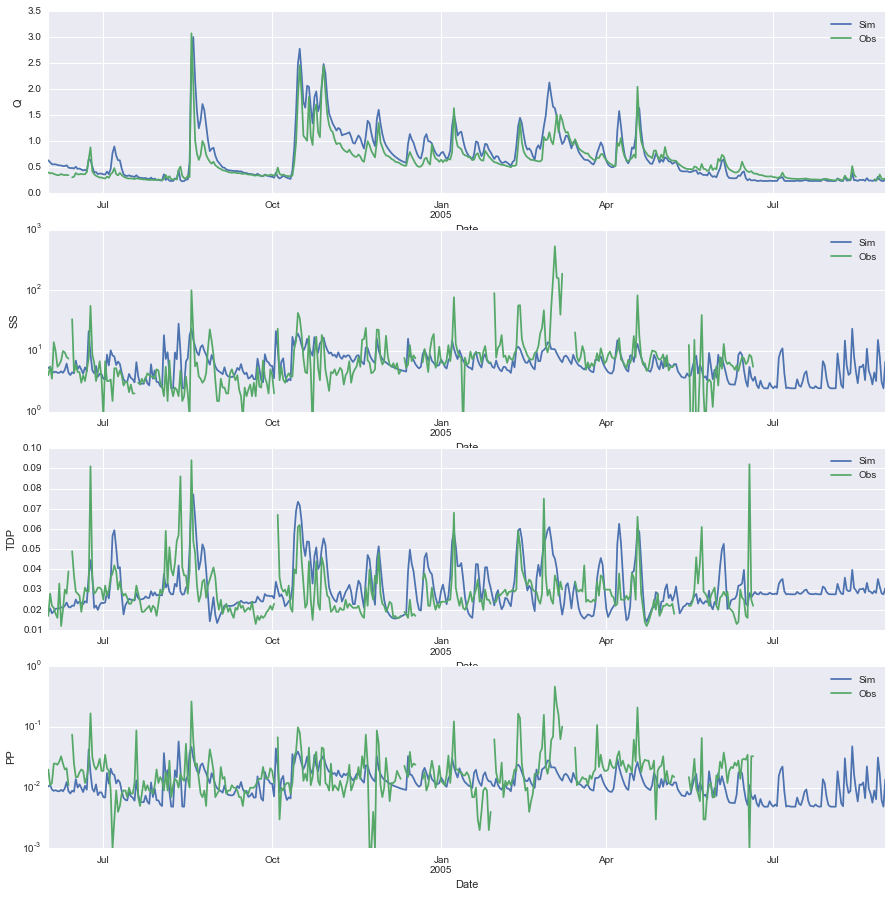

In [255]:
# EXAMINE OUTPUT

for SC in df_R_dict.keys():
    
    # EXTRACT DATA
    plot_df = plot_df_dict[SC] # Extract simulated data for this sub-catchment    
    if SC in obs_dict.keys():  # If have any observed data for this sub-catchment, extract it
        obs_df = obs_dict[SC]
    
    # PLOT TIMESERIES

    # TERRESTRIAL COMPARTMENT
    # fig3 = df[['VsA','VsS','QsA','TDPs_A_kgmm', 'Qg','Qr','TDPr_kgmm']].plot(subplots=True,figsize=(15, 10))
    # fig3 = df[['Plabile_mg/kg','EPC0_A_mgl','TDPs_mgl']].plot(subplots=True,figsize=(15, 10))
    # fig3 = df[['P_labile_A','P_labile_NC', 'EPC0_A_kgmm', 'EPC0_NC_kgmm']].plot(subplots=True,figsize=(15, 15))

    # IN-STREAM
    plot_var_li = ['Q','SS','TDP','PP']  # List of variables to plot
    
    logy_dict = {'Q':False, 'SS':True, 'TDP':False, 'PP':True}

    fig = plt.figure(figsize=(15,15))
    
    for i, var in enumerate(plot_var_li):
        ax = fig.add_subplot(len(plot_var_li),1,i+1)
        plot_df[var].plot(kind='line',ax=ax, logy=logy_dict[var], label='Sim') # Plot simulated data
        if var in obs_df.columns:  # If have observations for this reach, plot them & do a legend
            obs_df[var].plot(kind='line',ax=ax, logy=logy_dict[var], label='Obs')  # Observed
            ax.legend()
        plt.ylabel(var)  # y-axis label
        if var == 'SS':
            ax.set_ylim(1)
    # plt.subplots_adjust()
    plt.savefig(r'M:\Working\NewModel\ModelOutputs\Prototype_Timeseries_07-01-06.png')

    # PERFORMANCE METRICS
    stats_li = []
    for var in plot_var_li:
        obs = obs_df[var]
        sim = plot_df[var]
        tdf = pd.concat([obs,sim],axis=1)
        tdf.columns = ['obs','sim']
        log_obs = np.log(obs)
        log_sim = np.log(sim)
        tldf = pd.concat([log_obs,log_sim],axis=1)
        tldf.columns = ['obs','sim']

        NSE = 1 - (np.sum((tdf['obs']-tdf['sim'])**2)/np.sum((tdf['obs']-np.mean(tdf['obs']))**2))
        log_NSE = 1 - (np.sum((tldf['obs']-tldf['sim'])**2)/np.sum((tldf['obs']-np.mean(tldf['obs']))**2))
        spearmans_r_array = tdf.corr(method='spearman')
        r2_array = tdf.corr(method='pearson')**2
        spearmans_r = spearmans_r_array.ix[0,1]
        r2 = r2_array.ix[0,1]        
        stats_li.append([NSE, log_NSE, spearmans_r, r2])
        
    stats_df = pd.DataFrame(data=stats_li, columns=['NSE','log_NSE','spearmans_r','r2'], index=plot_var_li)

In [256]:
# df.to_csv('C:\Users\lj40184\Desktop\WorkAtHome\ModelOutputs\df_2yrs_meanFluxes_newODEs.csv')

In [257]:
stats_df

,NSE,log_NSE,spearmans_r,r2
Q,0.603910,0.717720,0.916163,0.821183
SS,0.006747,0.112166,0.377060,0.034149
TDP,-0.134623,-0.204427,0.392218,0.234677
PP,0.002519,-0.085537,0.233352,0.092537


In [258]:
# stats_df.to_csv(r'M:\Working\NewModel\ModelOutputs\Model_Stats_11-01-16.csv')

(0.0, 365)

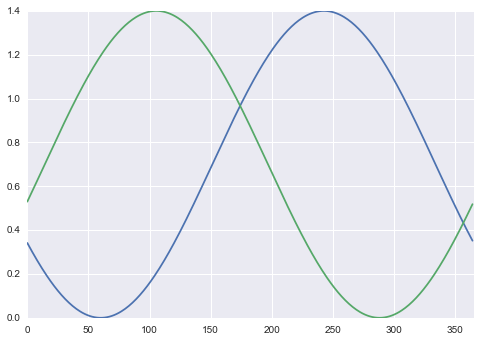

In [259]:
x = np.arange(0,365,1)
B1 = 60  # Spring cereals: 60, winter cereals: 
B2 = 288
y =0.7*(-np.cos((2*np.pi/365)*(x-B1))+1)
y2 = 0.7*(-np.cos((2*np.pi/365)*(x-B2))+1)
plt.plot(x,y)
plt.plot(x,y2)
plt.xlim(xmax=365)

In [260]:
annual_sum_df = df_TC_dict[1][['Mland_A','Mland_IG','Mland_S']].sum()
annual_sum_df
# annual_sum_df.to_csv(r'M:\Working\NewModel\ModelOutputs\Output_Tables\Annual_Mland_flux\')


Mland_A     89850.217260
Mland_IG    46725.355875
Mland_S     27256.457594
dtype: float64